In [3]:
""" Auto Encoder Example.
Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""

' Auto Encoder Example.\nUsing an auto encoder on MNIST handwritten digits.\nReferences:\n    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based\n    learning applied to document recognition." Proceedings of the IEEE,\n    86(11):2278-2324, November 1998.\nLinks:\n    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/\n'

In [5]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from l0_regularization import l0_regularizer

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# TensorBoard Graph Visualization

In [6]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [21]:
# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
reg_const = 1e-6 # ~ 1e3/n == 1e5-1e6 for MNIST



In [19]:
# tf Graph input (only pictures)
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():    
    X = tf.placeholder("float", [None, n_input])
    is_training = tf.placeholder(tf.bool, [], name='is_training')

    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([n_input])),
    }

    # Building the encoder
    def encoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                       biases['encoder_b1']))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                       biases['encoder_b2']))
        return layer_2


    # Building the decoder
    def decoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        return layer_2

    # Construct model
    with tf.variable_scope('encoder'):
        encoder_op = encoder(X)    
        add_loss, encoder_op = l0_regularizer(encoder_op, n_hidden_2, reg_const=reg_const)# l0_regularization on layer
        encoder_op = encoder_op(is_training)
        print(encoder_op)                
    
    with tf.variable_scope('decoder'):
        decoder_op = decoder(encoder_op)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + add_loss
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    # Launch the graph
    # Using InteractiveSession (more convenient while using Notebooks)
    sess = tf.InteractiveSession()
    sess.run(init)
tf.summary.FileWriter("logs", g).close()


Tensor("encoder/cond/Merge:0", shape=(?, 128), dtype=float32)


# Built Graph

In [20]:
show_graph(g)

# Training

In [22]:

total_batch = int(mnist.train.num_examples/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, is_training: True})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.164443567
Epoch: 0002 cost= 0.117728524
Epoch: 0003 cost= 0.100673981
Epoch: 0004 cost= 0.090669192
Epoch: 0005 cost= 0.084719598
Epoch: 0006 cost= 0.081858732
Epoch: 0007 cost= 0.079324394
Epoch: 0008 cost= 0.078254238
Epoch: 0009 cost= 0.074179061
Epoch: 0010 cost= 0.073033363
Optimization Finished!


/is/sg/klee/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


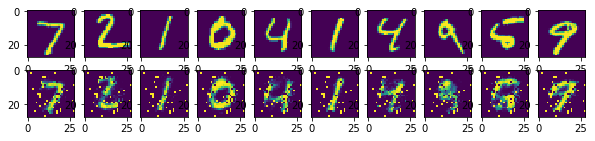

In [23]:
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
encoded_training = sess.run(encoder_op, 
                            feed_dict={X: mnist.test.images[:examples_to_show], is_training: True})
encoded_pred= sess.run(encoder_op, 
                       feed_dict={X: mnist.test.images[:examples_to_show], is_training: False})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    
f.show()
plt.show()

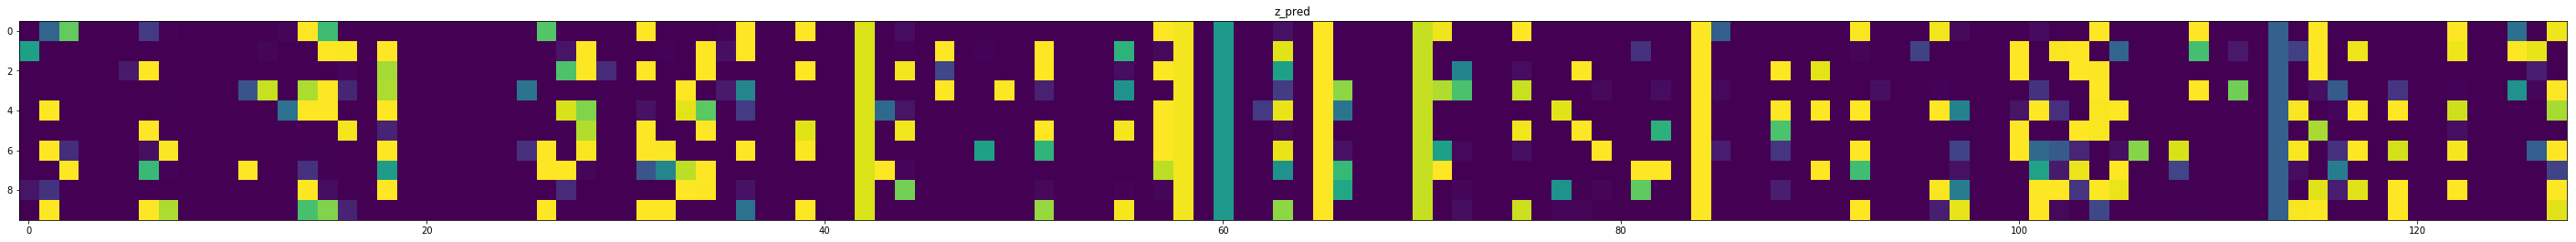

In [24]:
# latents for prediction
fig = plt.figure(figsize=(50, 300))
plt.imshow(encoded_pred)
plt.title('z_pred')

In [26]:
print(encoded_pred)

[[3.0209529e-10 3.2782665e-01 7.5923550e-01 ... 3.6613759e-01
  6.9156435e-08 9.7626698e-01]
 [5.6903321e-01 2.4424337e-13 1.0933258e-03 ... 9.9972469e-01
  9.6315354e-01 3.0490180e-13]
 [6.0831622e-04 8.1440593e-10 1.0306858e-05 ... 1.2387217e-07
  8.1487641e-02 1.5385056e-10]
 ...
 [8.3744157e-11 1.4638298e-04 9.9747425e-01 ... 5.2440834e-07
  1.4270186e-05 2.0670490e-01]
 [5.7324193e-02 1.4510548e-01 3.7188774e-03 ... 3.5786054e-03
  1.3474940e-11 9.9999845e-01]
 [1.1068476e-09 9.9849379e-01 8.7623669e-10 ... 8.0136012e-04
  5.2548012e-07 9.5546615e-01]]


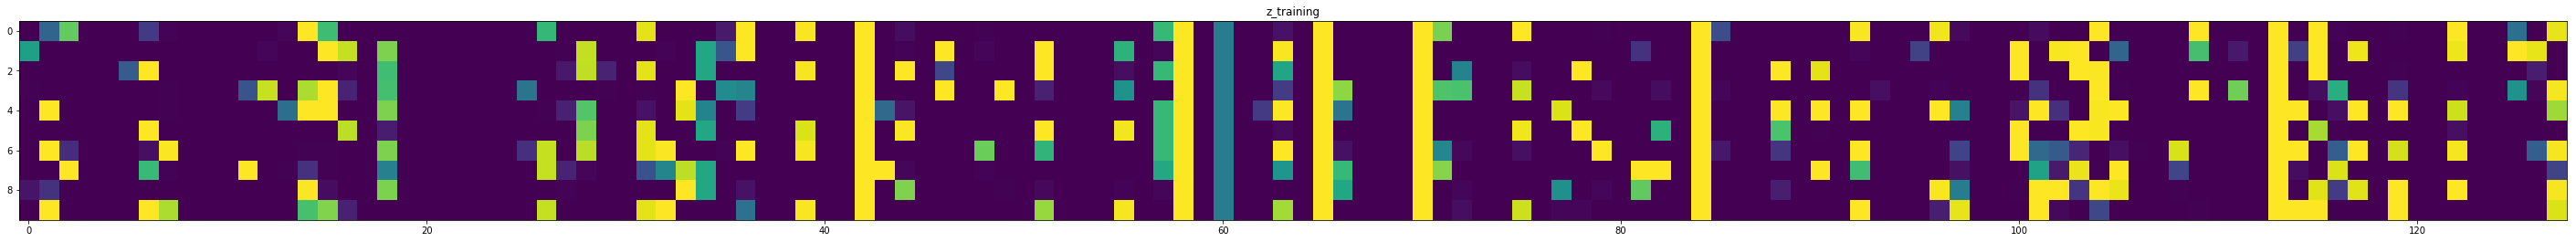

In [25]:
# latents for training
fig2 = plt.figure(figsize=(50, 300))
plt.imshow(encoded_training)
plt.title('z_training')

In [29]:
np.sum(encoded_pred - encoded_pred)

0.0